In [2]:
import geopandas as gpd
import numpy as np
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import rasterio


In [40]:

# Step 1: Load the GeoDataFrame with polygons and calculate the area of each polygon
votes_gdf = gpd.read_file('fl_2016/fl_2016.shp')

votes_gdf['blue'] = votes_gdf['G16PREDCLI'] + votes_gdf['G16USSDMUR'] # calculate votes for blue per precinct
votes_gdf['red'] = votes_gdf['G16PRERTRU'] + votes_gdf['G16USSRRUB'] # calculate votes for red per precinct

# Step 2: Reproject to a projected CRS
# Choose an appropriate projected CRS. EPSG:3857 (Pseudo-Mercator) or a UTM zone may be suitable.
votes_gdf_projected = votes_gdf.to_crs(epsg=3857)  # You can change EPSG code to a suitable one for your area

# Step 3: Calculate the area using the projected GeoDataFrame
votes_gdf_projected['area'] = votes_gdf_projected.geometry.area

# Define the attribute columns to be rasterized
selected_columns = ['blue', 'red']

# Step 2: Define the bounds and raster properties
minx, miny, maxx, maxy = votes_gdf_projected.total_bounds
pixel_size = 2000
width = int((maxx - minx) / pixel_size)
height = int((maxy - miny) / pixel_size)

# Set up the transform for the raster
transform = from_bounds(minx, miny, maxx, maxy, width, height)

# Step 3: Rasterize each attribute column separately into bands with fractional values
raster_bands = []

for col in selected_columns:
    # Generate shapes for rasterization, now including fractional values
    shapes = (
        (geom, value / area) for geom, value, area in zip(votes_gdf_projected.geometry, votes_gdf_projected[col], votes_gdf_projected['area'])
    )
    
    raster_band = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,
        dtype='float32'  # Using float to handle fractional values
    )
    raster_bands.append(raster_band)

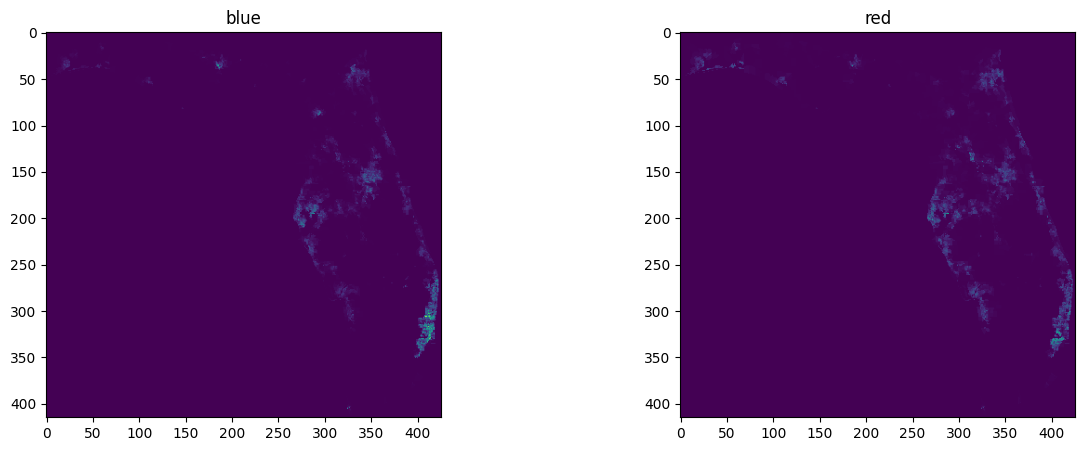

In [41]:
# Visualize one of the raster bands for verification (optional)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, len(selected_columns), figsize=(15, 5))
for i, band in enumerate(raster_bands):
    axs[i].imshow(band, cmap='viridis')
    axs[i].set_title(f'{selected_columns[i]}')
plt.show()


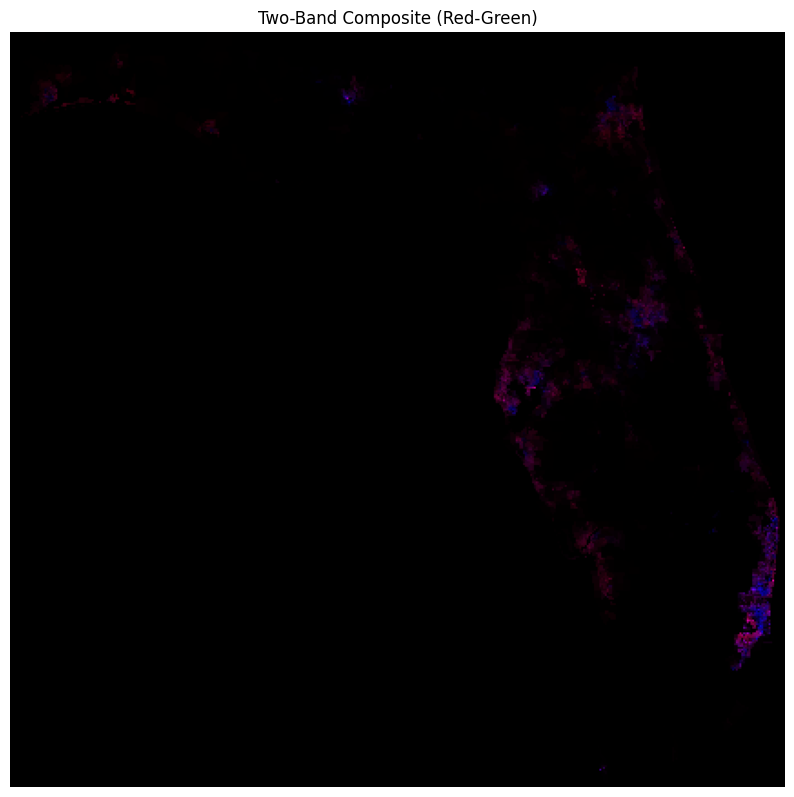

In [42]:
# Get the two bands
blue_band = raster_bands[0]
red_band = raster_bands[1]

# Normalize bands to [0, 1] for visualization
def normalize(array):
    return (array - array.min()) / (array.max() - array.min())

blue_norm = normalize(blue_band)
red_norm = normalize(red_band)
green_norm = np.zeros_like(red_norm)  # Set green channel to zero

# Stack bands to create an RGB image
rgb = np.dstack((red_norm, green_norm, blue_norm))

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title('Two-Band Composite (Red-Green)')
plt.axis('off')
plt.show()

In [50]:
import random

# Step 1: Create a mask for valid pixels (non-zero values in either band)
mask = (blue_band > 0) | (red_band > 0)  # Create a mask where either band has non-zero value

# Step 2: Find row and column indices of valid pixels
valid_pixels = np.argwhere(mask)

# Check if there are any valid pixels to sample from
if len(valid_pixels) == 0:
    print("No valid pixels found inside the state boundaries.")
else:
    # Step 3: Randomly choose one valid pixel from the list
    random_index = random.randint(0, len(valid_pixels) - 1)
    row, col = valid_pixels[random_index]

    # Step 4: Extract values from both bands at the selected pixel
    blue_value = blue_band[row, col]
    red_value = red_band[row, col]

    # Display the values for the randomly selected pixel
    print(f"Randomly selected pixel at (row {row}, col {col}):")
    print(f"  Value in Blue Band: {blue_value}")
    print(f"  Value in Red Band: {red_value}")

Randomly selected pixel at (row 134, col 295):
  Value in Blue Band: 8.780413736531045e-06
  Value in Red Band: 2.3200951545732096e-05
